## Helper Functions

In [9]:
def export_test_csv(df,name,sep=","):
    df.to_csv("../test_exports/"+name+".csv",sep=sep)

In [10]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

In [11]:
#Helper function to find a spot in a matrix
def findSpot(matrix,plot):
    maxrows = matrix.shape[0] #amount of rows
    maxcols = matrix.shape[1] #amount of cols
    
    rowc = -1
    for row in matrix:
        rowc = rowc+1
        itemc = -1
        for item in row:
            itemc = itemc + 1
            if (rowc + plot[0] > maxrows) or (itemc + plot[1] > maxcols):
                continue
            if item == 0: #find potential spot
                space = True
                for i in range(rowc,rowc+plot[0]):#find out whether it fits
                    for u in range(itemc,plot[1]):
                        if matrix[i,u] == 1: 
                            space = False
                if space:
                    return((rowc,itemc))
    return False


In [35]:
# Create Subplot, return figure and array of axes
def create_subplot_fig(title = "Unnamed Plot",figsize=(12,8),x=1,y=1,names=[],tight_layout=False):
    
    fig,axes = plt.subplots(nrows=y,ncols=x,figsize=figsize)
    fig = style_fig(fig,title=title,tight_layout=tight_layout)

    if x*y == 1:
        axes = np.array([axes])
    
    if x>1 and y>1:
        axes = axes.flatten()

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')

    # case more than one
    if len(names) == x*y:
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i = i+1                 
    return fig,axes

#Create a gridplot that automatically arranges plots from left to right and horizontally
def create_gridplot(title="Unnamed Plot",figsize=(12,8),gridsize=(6,3),plotsizes=[(3,2),(1,1),(1,2)],direction="h",names=[],tight_layout=False):
    fig  = create_fig(title=title,figsize=figsize)
    fig=style_fig(fig,title=title,tight_layout=tight_layout)
    
    axes = []
    taken = np.zeros(gridsize)
    
    if direction == "h":
        for plot in plotsizes:
            spot = findSpot(taken,plot)
            if spot:
                for i in range(spot[0],spot[0]+plot[0]):
                    for u in range(spot[1],spot[1]+plot[1]):
                        taken[i,u] = 1
                axes.append(plt.subplot2grid(gridsize, spot, colspan=plot[1], rowspan=plot[0]))
            else: 
                print("no spot found")
    else: 
        print("Vertical Option is not implemented yet")

    for ax in axes:
        ax.ticklabel_format(axis='both', style='plain')
        
    if len(axes) == len(names):
        i = 0
        for ax in axes:
            ax.set_title(names[i],fontname="Arial",y=1.0)
            i=i+1
    return fig,axes



# Give Figure a styling
def style_fig(fig,title="Unnamed Plot",tight_layout=False):
    fig.suptitle(title, x=0.5, y=0.98, color='black',size=15,fontname="Arial")
    if tight_layout:
        print("Tight Layout activated")
        fig.tight_layout()
    return fig

# create figure
def create_fig(title = "Unnamed Plot",figsize=(12,8)):
    fig = plt.figure(figsize = figsize)
    fig = style_fig(fig,title)
    return fig

___________________________

# 0. Data Preparation

#### Python Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
from fastparquet import write
import parquet
import contextily as ctx
import seaborn as sns

#### Data Read-In

In [3]:
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")
df = df.sample(10000)

In [17]:
weather_hourly = pd.read_parquet("../data/weather_transformed_23_08_2021.parquet")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 8859241 to 10553759
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Trip ID                     10000 non-null  object        
 1   Taxi ID                     9998 non-null   object        
 2   Trip Start Timestamp        10000 non-null  datetime64[ns]
 3   Trip End Timestamp          10000 non-null  datetime64[ns]
 4   Trip Seconds                10000 non-null  float64       
 5   Trip Miles                  10000 non-null  float64       
 6   Pickup Census Tract         7022 non-null   float64       
 7   Dropoff Census Tract        6986 non-null   float64       
 8   Pickup Community Area       9304 non-null   float64       
 9   Dropoff Community Area      9095 non-null   float64       
 10  Fare                        10000 non-null  float64       
 11  Tips                        10000 non-null  f

### Fleet Size Calculation

We first want to find out how long most taxis in our fleet operate. It seems like the majority of Taxi IDs operates throughout a significant amount of days within our analysis time frame.
We define the size of the fleet as the amount of Taxis that had at least one ride within the last 7 days.

In [7]:
days=7

# Build Table with date ranges
date_range = pd.date_range(start=df.PU_DATE.min(), end=df.DO_DATE.max(),freq="1d")
date_range_df = pd.DataFrame(index=date_range)

date_range_df["min_date"]=date_range.date-pd.Timedelta(days=days)
date_range_df["max_date"]=date_range.date

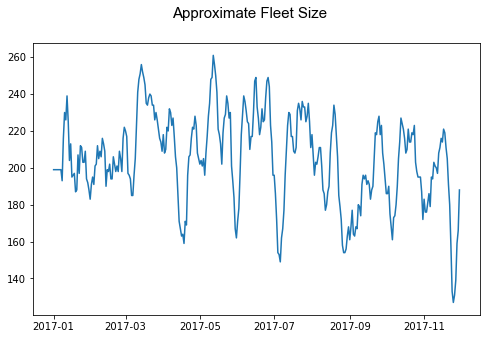

In [13]:
def get_fleet_size(min_date,max_date):
    #the number of unique Taxi IDs that have driven at least once within the given Time Frame
    return len(df[(df["PU_DATE"]>min_date) & (df["PU_DATE"]<=max_date)]["Taxi ID"].unique())

#calculate fleet size for every day in date range
fleet_size = []
for _,row in date_range_df.iterrows():
    maxdate = row["max_date"]
    mindate = row["min_date"]
    fsize = get_fleet_size(mindate,maxdate)
    fleet_size.append({"date":maxdate,
                        "fleet_size":fsize
                       })
    
fleet_size=pd.DataFrame(fleet_size)

# Set static fleet size for first days (as there is no data for)
first_value=fleet_size["fleet_size"].iloc[days-1]
i=0
for i in range(0,days-1):
    fleet_size.iloc[i,1] = first_value
    
# Plot Fleet Size over the year
fig,axes=create_subplot_fig(title = "Approximate Fleet Size",figsize=(8,5))
_= axes[0].plot(fleet_size.date,fleet_size.fleet_size)

## Build different aggregation levels

In [15]:
df_daily = df.groupby("PU_DATE").agg(daily_trips=("PU_DATE","count"),
                                                 DATE=("PU_DATE","min"))
df_daily = pd.merge(df_daily,fleet_size,left_index=True,right_on="date",how="left")


df_hourly = df.groupby(["PU_DATE","PU_HOUR"]).agg(trip_count=("PU_HOUR","count"),
                                                 HOUR=("PU_HOUR","min"),
                                                 DATE=("PU_DATE","min"),
                                                 trip_duration = ("Trip Seconds","median"),
                                                 workday=("PU_isWorkday","min"),
                                                 mph = ("MPH","median"))
df_hourly = pd.merge(df_hourly,df_daily,how="left",left_on = "DATE",right_on="DATE")

df_hourly["relative_trips"] = (df_hourly["trip_count"] / df_hourly["daily_trips"])*100

df_weekly = df.groupby("PU_WEEK").agg(count=("Trip ID","count"))
                                      
df_monthly = df.groupby("PU_MONTH").agg(PU_MONTH_NAME=("PU_MONTH_NAME","min"),
                                        count=("Trip ID","count"),
                                        fare_avg=("Fare","mean"),
                                        tips_avg=("Tips","mean"),
                                        tolls_avg=("Tolls","mean"),
                                        extras_avg=("Extras","mean")
                                       )

df_weekday = df.groupby("PU_WEEKDAY").agg(WEEKDAY_NAME=("PU_WEEKDAY_NAME","min"),
                                         count=("Trip ID","count"))



df_hourly.head(3)

,trip_count,HOUR,DATE,trip_duration,workday,mph,daily_trips,date,fleet_size,relative_trips
0,2,1,2017-01-01,880.0,False,6.330857,26,2017-01-01,199,7.692308
1,3,2,2017-01-01,480.0,False,6.750000,26,2017-01-01,199,11.538462
2,3,3,2017-01-01,438.0,False,9.000000,26,2017-01-01,199,11.538462


In [18]:
weather_daily = weather_hourly.groupby("date").agg(date=("date","first"),
                                                   temperature_avg =("Temperature","mean"),
                                                   humidity_avg = ("Humidity","mean"),
                                                   windspeed_avg = ("Wind Speed","mean"),
                                                   weather_desc_dominant = ('weather_description', lambda x: x.value_counts().index[0]),
                                                   has_precipitation = ("has_precipitation","max"), #returns weather there was at least one instance of precipitation
                                                   precipitation_hours =("has_precipitation","sum") #Sums up all True Instances in a day
                                                  )

weather_monthly = weather_hourly.groupby("month").agg(date=("date","first"),
                                                   temperature_avg =("Temperature","mean"),
                                                   humidity_avg = ("Humidity","mean"),
                                                   windspeed_avg = ("Wind Speed","mean"),
                                                   weather_desc_dominant = ('weather_description', lambda x: x.value_counts().index[0]),
                                                   has_precipitation = ("has_precipitation","max"), #returns weather there was at least one instance of precipitation
                                                   precipitation_hours =("has_precipitation","sum") #Sums up all True Instances in a day
                                                  )

## Descriptive Analysis - Weather

Tight Layout activated


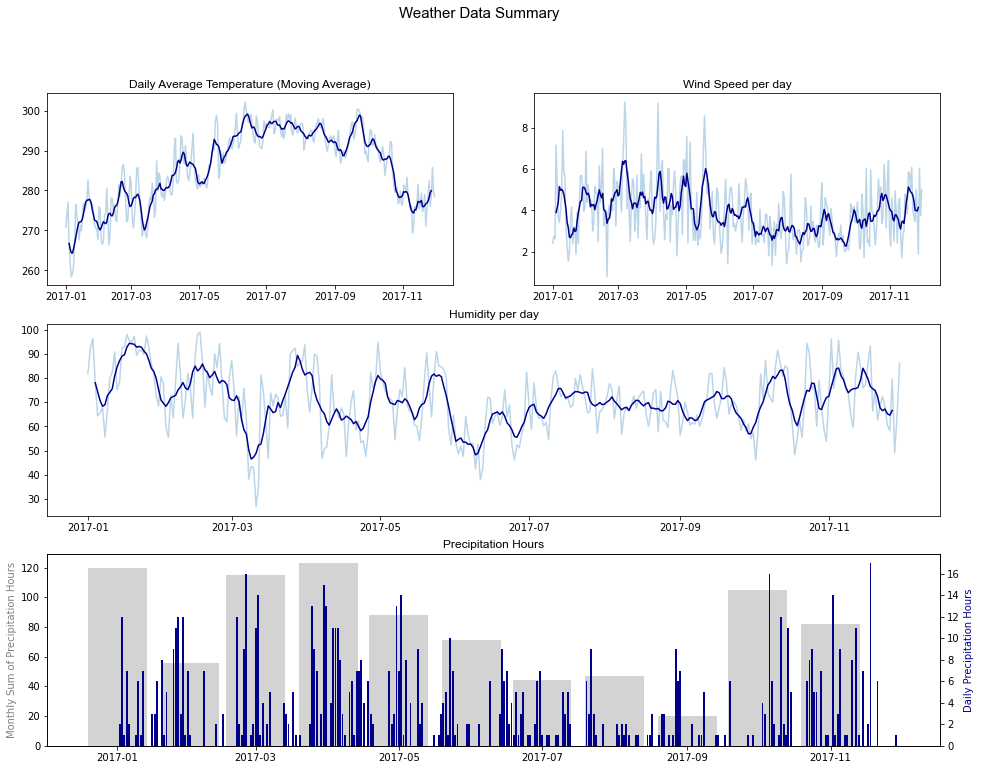

In [41]:
## Achsenbeschriftungen
fig,ax=create_gridplot(title="Weather Data Summary",
                       figsize=(16,12),
                       gridsize=(3,2),
                       plotsizes=[(1,1),(1,1),(1,2),(1,2)],
                       names=['Daily Average Temperature (Moving Average)',
                              'Wind Speed per day',
                              'Humidity per day',
                              "Precipitation Hours"],
                      tight_layout=True
                      )

# Exact Values
ax[0].plot(weather_daily["date"],weather_daily["temperature_avg"],alpha=0.3)
ax[1].plot(weather_daily["date"],weather_daily["windspeed_avg"],alpha=0.3)
ax[2].plot(weather_daily["date"],weather_daily["humidity_avg"],alpha=0.3)
ax[3].bar(weather_monthly["date"],height=weather_monthly["precipitation_hours"],
          width=25,zorder=2,color="lightgrey")
ax[3].set_ylabel("Monthly Sum of Precipitation Hours",color="grey")

# Rolling Averages
ax[0].plot(weather_daily["date"],
           weather_daily["temperature_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax[1].plot(weather_daily["date"],
           weather_daily["windspeed_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax[2].plot(weather_daily["date"],
           weather_daily["humidity_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax3month = ax[3].twinx() 
_=ax3month.bar(weather_daily["date"],height=weather_daily["precipitation_hours"],color="darkblue",zorder=1)
_=ax3month.set_ylabel("Daily Precipitation Hours",color="darkblue")

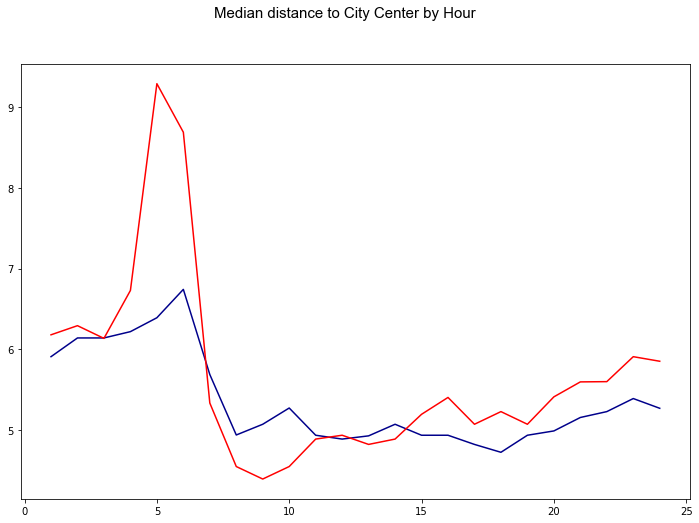

In [26]:
df_city_center=df.groupby(["PU_DATE","PU_HOUR"]).agg(PU_DATE=("PU_DATE","first"),
                                                     PU_HOUR=("PU_HOUR","first"),
                                                     pu_dist=("PU_DISTANCE_CITY","median"),
                                                     do_dist=("DO_DISTANCE_CITY","median"))
df_city_center_avg=df.groupby("PU_HOUR").agg(PU_HOUR=("PU_HOUR","first"),
                                              pu_dist=("PU_DISTANCE_CITY","median"),
                                              do_dist=("DO_DISTANCE_CITY","median"))
fig,ax=create_subplot_fig(title="Median distance to City Center by Hour",figsize=(12,8))
#for date in df_city_center["PU_DATE"].unique():
#    df_f = df_city_center[df_city_center["PU_DATE"]==date]
#    ax[0].plot(df_f["PU_HOUR"],df_f["pu_dist"],color="lightgrey")
ax[0].plot(df_city_center_avg["PU_HOUR"],df_city_center_avg["pu_dist"],color="darkblue")
ax[0].plot(df_city_center_avg["PU_HOUR"],df_city_center_avg["do_dist"],color="red")
#ax[0].set_ylim(3,20)

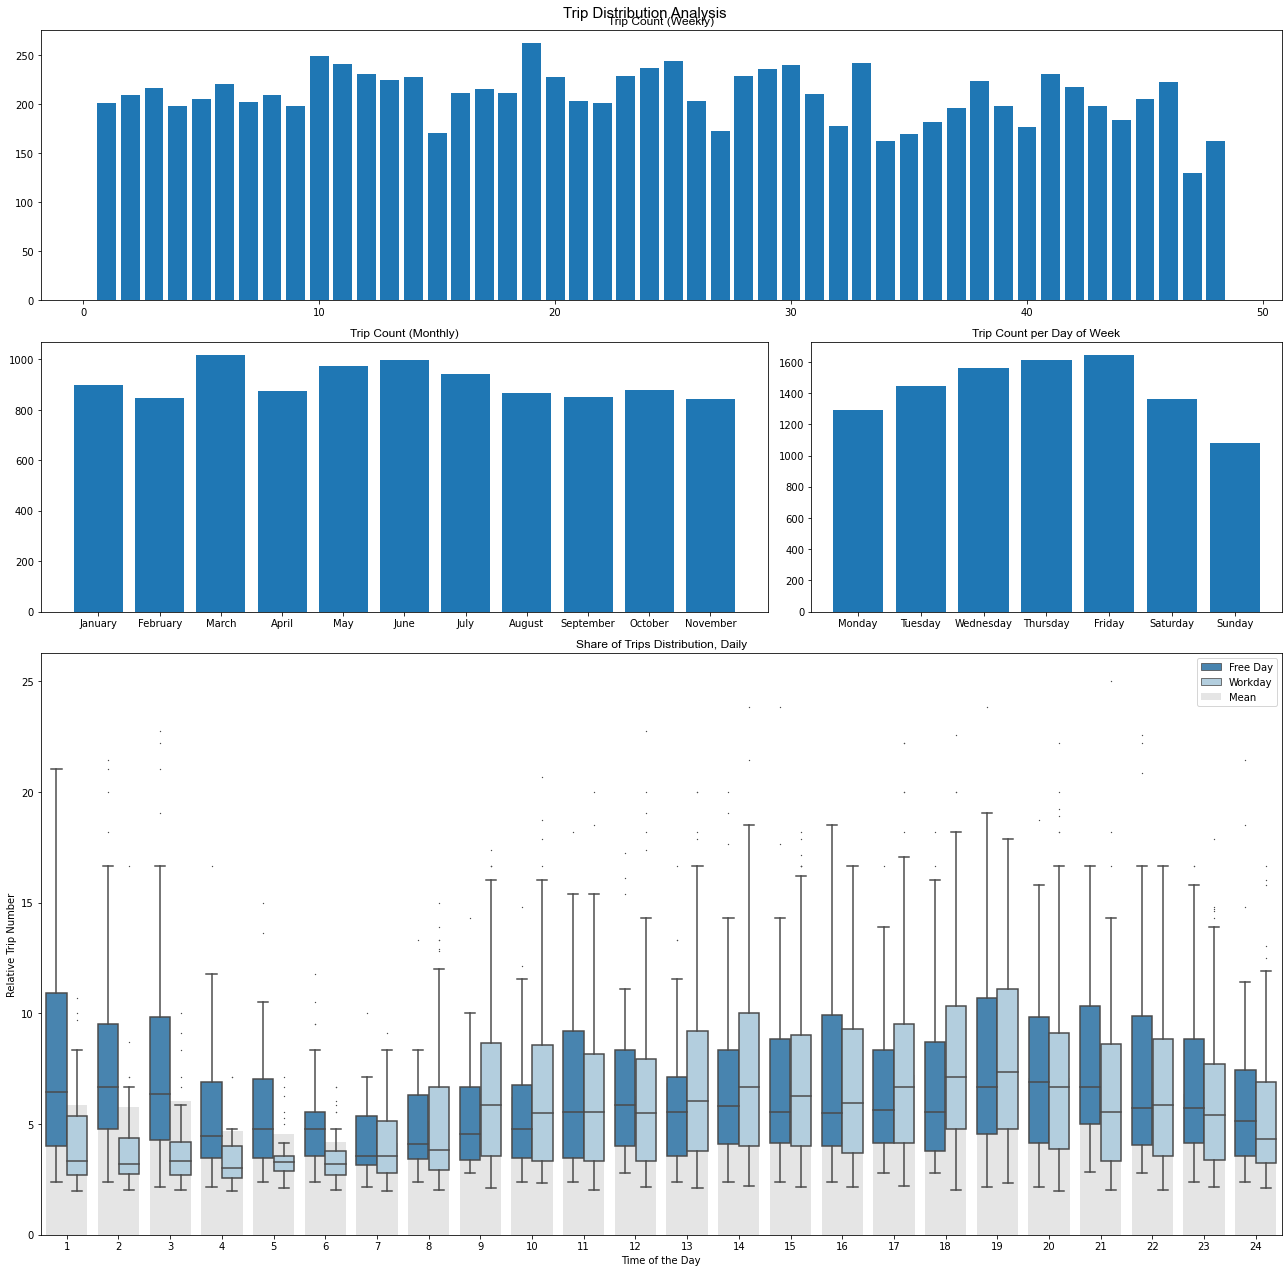

In [44]:
## Labels erneuern

fig,ax=create_gridplot(title="Trip Distribution Analysis",
                       figsize=(18,18),gridsize=(4,5),plotsizes=[(1,5),(1,3),(1,2),(2,5)],
                       names=['Trip Count (Weekly)','Trip Count (Monthly)','Trip Count per Day of Week',"Share of Trips Distribution, Daily"])


ax[0].bar(df_weekly.index,df_weekly["count"])
ax[1].bar(df_monthly["PU_MONTH_NAME"],df_monthly["count"])
ax[2].bar(x=df_weekday["WEEKDAY_NAME"],height=df_weekday["count"])


color_palette = "Blues_r"
boxplot = sns.boxplot(ax = ax[3],
                 data=df_hourly, 
                 x="HOUR", 
                 y="relative_trips", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("relative_trips","mean"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax[3],
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax[3].get_legend_handles_labels()
ax[3].legend(handles, ["Free Day", "Workday","Mean"], loc="best")

fig.tight_layout()
_=ax[3].set_ylabel('Relative Trip Number')
_=ax[3].set_xlabel('Time of the Day')

### Analysis of Trip Number

### Analysis of MPH

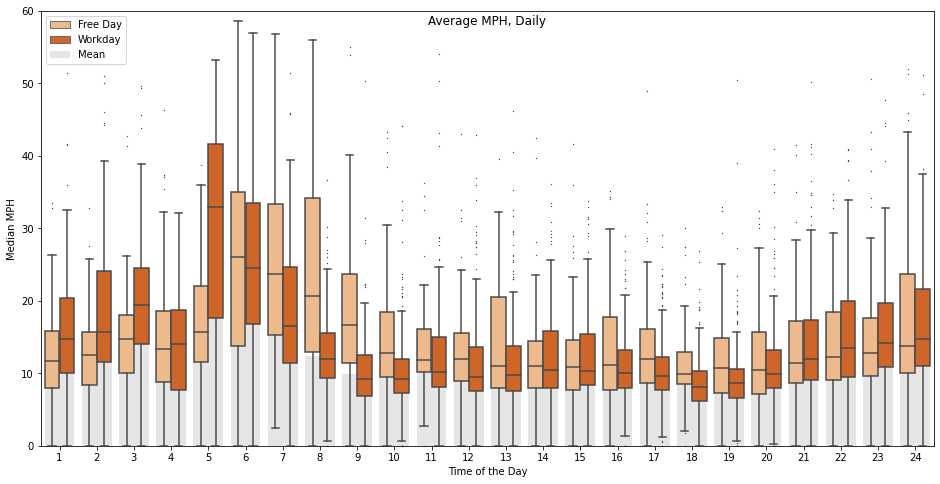

In [45]:
fig,ax = plt.subplots(1, 1, figsize=(16, 8))

color_palette = "Oranges"
boxplot = sns.boxplot(ax = ax,
                 data=df_hourly, 
                 x="HOUR", 
                 y="mph", 
                 hue='workday', 
                 palette=color_palette,
                 zorder = 1,
                     fliersize=0.5)


df_hourly_avg = df_hourly.groupby("HOUR").agg(avg = ("mph","median"))
avg = sns.barplot(x=df_hourly_avg.index,
                   y=df_hourly_avg.avg,
                   zorder = 0,
                   ax = ax,
                   color="black",
                   linewidth=20,
                   alpha = 0.1,
                 label = "average")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Free Day", "Workday","Mean"], loc="best")

ax.set_ylim(0,60)
_=ax.set_title("Average MPH, Daily",y=1.0, pad=-14)
_=ax.set_ylabel('Median MPH')
_=ax.set_xlabel('Time of the Day')

<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='month'>

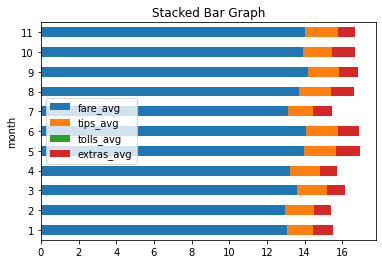

In [30]:
# Revenue pro Fahrzeug?

df_monthly_payment = df_monthly.copy()[["fare_avg","tips_avg","tolls_avg","extras_avg"]]
df_monthly_payment["month"] = df_monthly_payment.index

fig,ax=plt.subplots()
df_monthly_payment.plot(
    x = "month",
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    ax=ax)

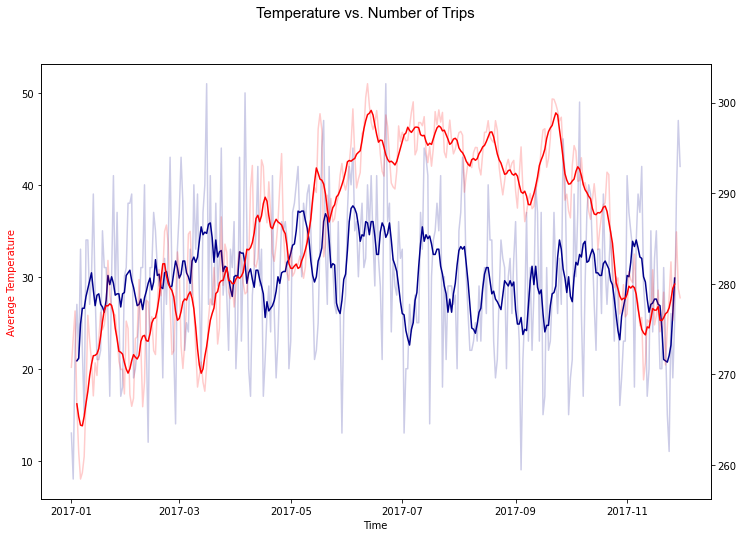

In [31]:
fig,ax = create_subplot_fig(title = "Temperature vs. Number of Trips",figsize=(12,8),x=1,y=1,names=[""])
ax[0].set_ylabel('Average Temperature', color='red')
ax[0].set_xlabel('Time')

ax[0].plot(df_daily["DATE"],df_daily["daily_trips"],alpha=0.2,color="darkblue")
ax[0].plot(df_daily["DATE"],
           df_daily["daily_trips"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="darkblue")

ax2 = ax[0].twinx()
ax2.plot(weather_daily["date"],weather_daily["temperature_avg"],alpha=0.2,color="red")
ax2.plot(weather_daily["date"],
           weather_daily["temperature_avg"].rolling(window=7,center=True).mean(),
           alpha=1, 
           color="red")


____________________________________________________

## Geospatial Analysis
For analysis of geo data, we have to limit our dataset to the rides that have valid spatial data for Pickup and Dropoff.


In [47]:
df_geo = df.copy()[(~df["PU_H3"].isnull()&~df["DO_H3"].isnull())]
left=np.round(len(df_geo.index)/len(df.index)*100,2)
print(len(df_geo.index),"Records from",len(df.index),"remained after geo-cleaning.","("+str(left)+"%)")
df_geo.head(3)

9052 Records from 10000 remained after geo-cleaning. (90.52%)


,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
11921451,118d8e99905b49749f4d5cf78aea4f4eaaf5a36e,309a3fcadd8449de254553358c8ea1d9df6305e8b48182...,2017-06-14 23:00:00,2017-06-14 23:15:00,1242.0,5.72,NaN,NaN,8.0,24.0,...,24,True,June,Wednesday,24,2017-06-14,6,2,24,True
13455469,19f00a62a65918dfcc26ffe8c1627ed6e42af96e,995b6bbd9193c65ec96fba1f5ad0f412810baeea05f2b3...,2017-07-07 14:15:00,2017-07-07 14:45:00,1800.0,10.80,1.703128e+10,1.703198e+10,28.0,56.0,...,15,True,July,Friday,27,2017-07-07,7,4,15,True
21011231,9c44c829b6ee58c2cfd4bf3923b8be9f0054adc5,89dea8fe744d5636183373475f8bdbaa6e075692973f97...,2017-10-26 22:15:00,2017-10-26 22:30:00,780.0,4.70,NaN,NaN,32.0,6.0,...,23,True,October,Thursday,43,2017-10-26,10,3,23,True


### Trajectory Visualisation
For trajectory visualisation with Kepler, we build an aggregated dataframe that contains the combination of all Pickup to Dropoff Hexagons that exist in our data. We also need to convert to our desired H3 Resolution, as this is set to 9 per default from our data cleaning part. This is way too detailed for our purposes. We choose a resolution of 7 instead.

In [74]:
h3_res = 7
df_geo["PU_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],h3_res),axis=1)
df_geo["DO_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],h3_res),axis=1)

In [75]:
def get_centroid(poly):
    return poly.centroid

def get_poly(h3_hex):
    return shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_hex,geo_json=True))


df_geo_traj = df_geo.groupby(["PU_H3","DO_H3"]).agg(count=("Trip ID","count"),
                                                            PU_H3=("PU_H3","first"),
                                                            DO_H3=("DO_H3","first"))

df_geo_traj["PU_H3_poly"]=df_geo_traj.apply(lambda x: get_poly(x["PU_H3"]),axis=1)
df_geo_traj["DO_H3_poly"]=df_geo_traj.apply(lambda x: get_poly(x["DO_H3"]),axis=1)

df_geo_traj["PU_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["PU_H3_poly"]),axis=1)
df_geo_traj["DO_H3_centroid"]=df_geo_traj.apply(lambda x: get_centroid(x["DO_H3_poly"]),axis=1)

df_geo_traj["PU_x"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.x)
df_geo_traj["PU_y"]=df_geo_traj["PU_H3_centroid"].map(lambda p: p.y)
df_geo_traj["DO_x"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.x)
df_geo_traj["DO_y"]=df_geo_traj["DO_H3_centroid"].map(lambda p: p.y)

<AxesSubplot:>

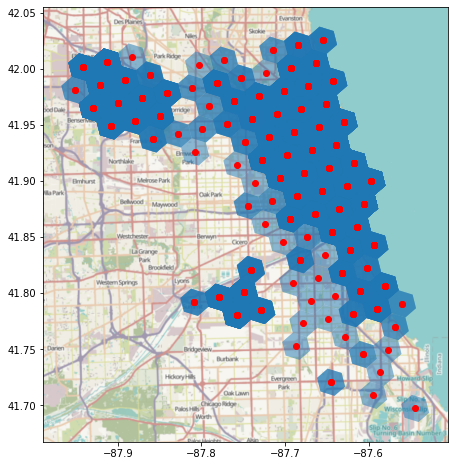

In [76]:
chicago = gpd.read_file("../data/chicago.geojson")
fig,ax=plt.subplots(figsize=(12,8))
gpd.GeoDataFrame(df_geo_traj,geometry="PU_H3_poly").plot(ax=ax,alpha=0.5)
gpd.GeoDataFrame(df_geo_traj,geometry="PU_H3_centroid").plot(color="red",ax=ax,alpha=1)
ctx.add_basemap(ax=ax,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago.plot(ax=ax,alpha=0)

In [80]:
export_test_csv(df_geo_traj[["PU_H3","DO_H3","count","PU_x","PU_y","DO_x","DO_y"]],name="trajectory_df")

In [82]:
from keplergl import KeplerGl
import json

#Import Kepler Config to 
with open("./kepler_configs/trajectorymap.json") as f:
    traj_config = json.load(f)
                            
                            
keplermap = KeplerGl(height=600,config=traj_config)
keplermap.add_data(data=df_geo_traj[["PU_H3","DO_H3","count","PU_x","PU_y","DO_x","DO_y"]], name="2my2ehvgj")

keplermap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'vioqxss', 'type': …

In [59]:
slices = 4
slicer = 24/slices

df_geo["slice"] = np.ceil(df_geo["PU_HOUR"]/slicer).astype(int)

df_geo[["Trip Start Timestamp","PU_HOUR","slice"]].sample(10)

,Trip Start Timestamp,PU_HOUR,slice
13483535,2017-07-07 20:30:00,21,4
22391635,2017-11-16 13:00:00,14,3
22782518,2017-11-22 23:30:00,24,4
4416668,2017-03-08 14:15:00,15,3
2201910,2017-02-04 00:45:00,1,1
17584684,2017-09-07 17:15:00,18,3
6201273,2017-03-31 12:45:00,13,3
15417603,2017-08-04 15:45:00,16,3
1952796,2017-01-31 18:00:00,19,4
1448616,2017-01-23 23:00:00,24,4


In [62]:
df_geo_pu = df_geo.groupby(["PU_H3","slice"]).agg(count=("PU_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("PU_H3","first")
                                            )
df_geo_pu["geometry"]= df_geo_pu.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_pu = gpd.GeoDataFrame(df_geo_pu,geometry="geometry")


df_geo_do = df_geo.groupby(["DO_H3","slice"]).agg(count=("DO_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("DO_H3","first")
                                           )
df_geo_do["geometry"]= df_geo_do.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_do = gpd.GeoDataFrame(df_geo_do,geometry="geometry")

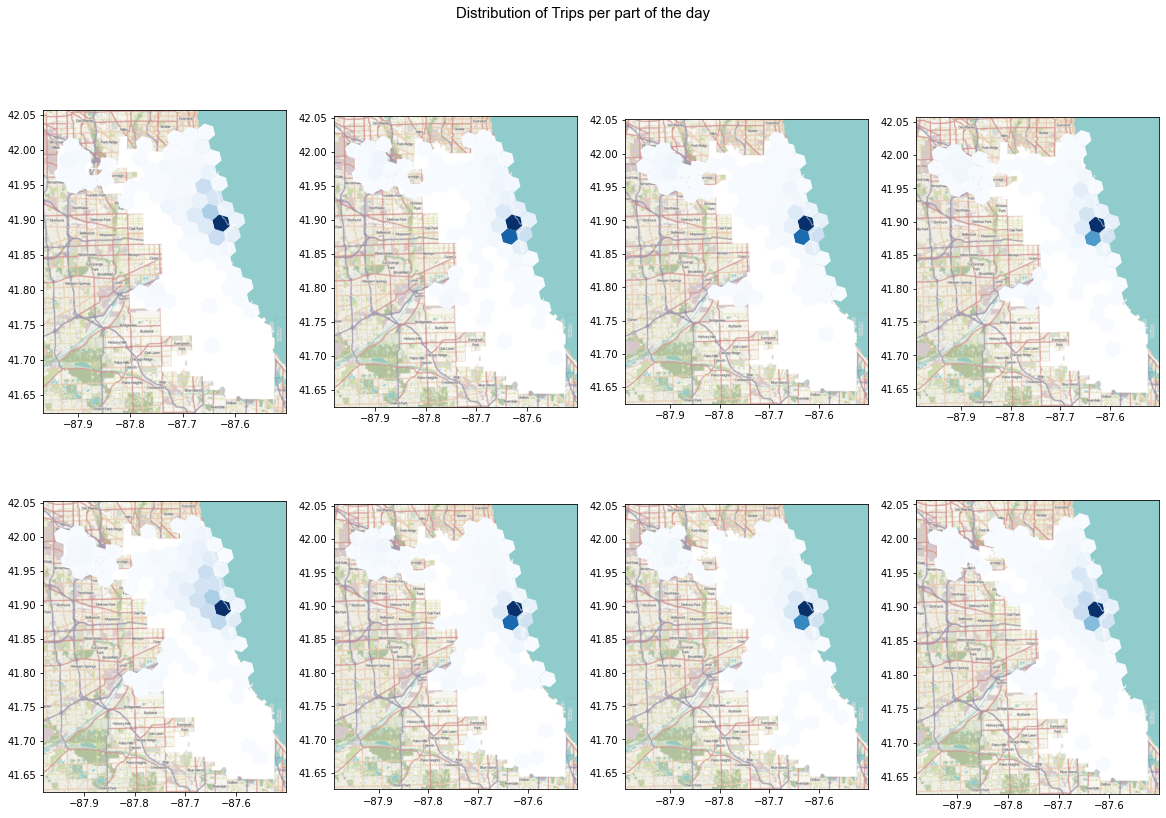

In [65]:
fig,axes = create_subplot_fig(title = "Distribution of Trips per part of the day",figsize=(20,13),x=4,y=2,names=["0-5h","6-11h","12-17h","18-23h"])
for i in range(0,4):
    chicago.plot(ax=axes[i],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_pu[df_geo_pu["slice"]==i+1],geometry="geometry").plot(ax=axes[i],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i],color="none",edgecolor="white",alpha=0.5)
    
    chicago.plot(ax=axes[i+4],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_do[df_geo_do["slice"]==i+1],geometry="geometry").plot(ax=axes[i+4],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i+4],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i+4],color="none",edgecolor="white",alpha=0.6)
    
    
    #axes[i].set_xlim(-87.7,-87.58)
    #axes[i].set_ylim(41.8,41.95)
    
    #axes[i+4].set_xlim(-87.7,-87.58)
    #axes[i+4].set_ylim(41.8,41.95)

In [68]:
h3_res = 6
df_geo["PU_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],h3_res),axis=1)
df_geo["DO_H3"] = df_geo.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],h3_res),axis=1)

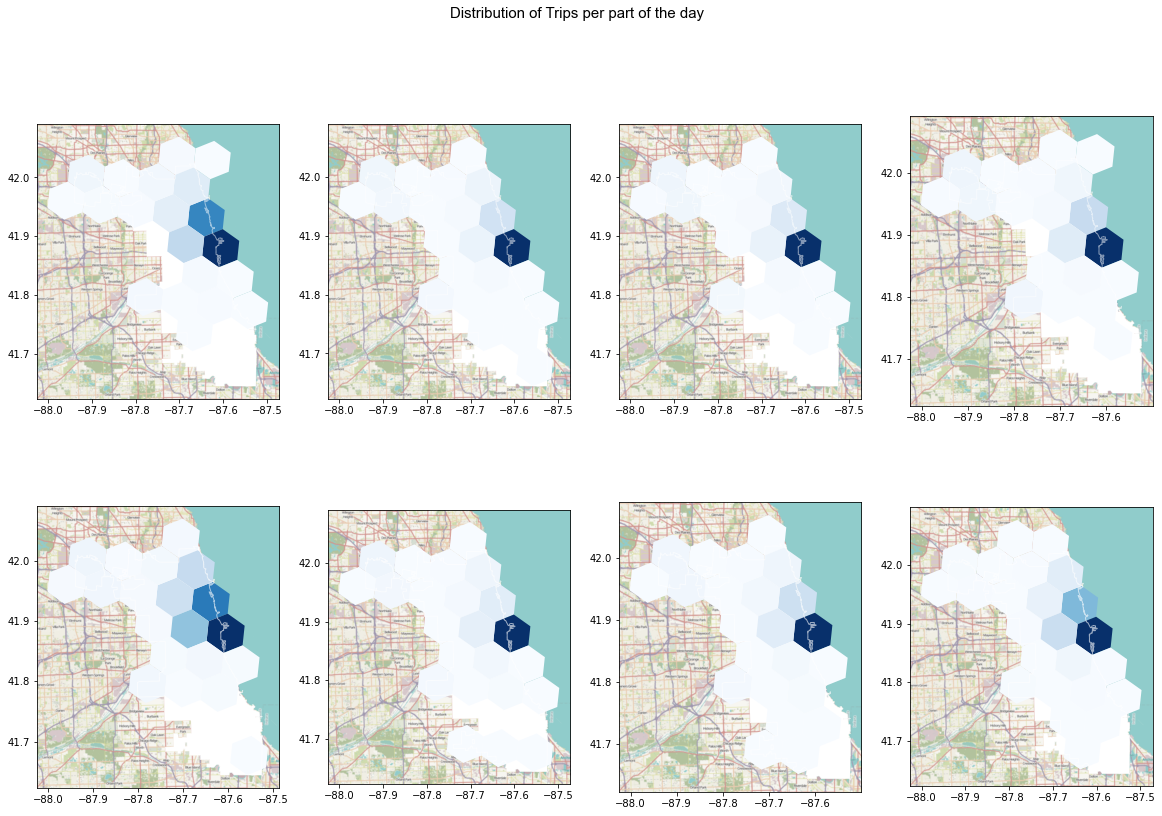

In [69]:
df_geo_pu = df_geo.groupby(["PU_H3","slice"]).agg(count=("PU_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("PU_H3","first")
                                            )
df_geo_pu["geometry"]= df_geo_pu.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_pu = gpd.GeoDataFrame(df_geo_pu,geometry="geometry")


df_geo_do = df_geo.groupby(["DO_H3","slice"]).agg(count=("DO_H3","count"),
                                                    slice=("slice","first"),
                                                    H3_id=("DO_H3","first")
                                           )
df_geo_do["geometry"]= df_geo_do.apply(lambda x: get_poly(x["H3_id"]),axis=1)
df_geo_do = gpd.GeoDataFrame(df_geo_do,geometry="geometry")

fig,axes = create_subplot_fig(title = "Distribution of Trips per part of the day",figsize=(20,13),x=4,y=2,names=["0-5h","6-11h","12-17h","18-23h"])
for i in range(0,4):
    chicago.plot(ax=axes[i],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_pu[df_geo_pu["slice"]==i+1],geometry="geometry").plot(ax=axes[i],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i],color="none",edgecolor="white",alpha=0.5)
    
    chicago.plot(ax=axes[i+4],color="white",alpha=1)
    gpd.GeoDataFrame(df_geo_do[df_geo_do["slice"]==i+1],geometry="geometry").plot(ax=axes[i+4],column="count",cmap="Blues")
    ctx.add_basemap(ax=axes[i+4],crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago.plot(ax=axes[i+4],color="none",edgecolor="white",alpha=0.6)

# BACKUP

In [4]:
df_raw = pd.read_parquet("../data/df_sample_21_06_2021.parquet")

NameError: name 'pd' is not defined

In [5]:
df_raw[df_raw["Pickup Centroid Location"].isnull() & ~df_raw["Dropoff Centroid  Location"].isnull()]

NameError: name 'df_raw' is not defined

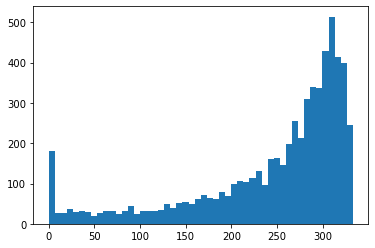

In [15]:
taxi_id_anal= df.groupby("Taxi ID").agg(min_date=("PU_DATE","min"),
                                         max_date=("PU_DATE","max"),
                                         count=("PU_DATE","count"))
taxi_id_anal["length"]=pd.to_timedelta(taxi_id_anal["max_date"]-taxi_id_anal["min_date"]).dt.days
_=plt.hist(taxi_id_anal.length,bins=50)

In [38]:
chicago_fence = gpd.read_file("../data/chicago.geojson")
chicago_boundary_pol = chicago_fence.geometry[0][1]
poly_geojson = gpd.GeoSeries([chicago_boundary_pol]).__geo_interface__
# Parse out geometry key from GeoJSON dictionary
poly_geojson = poly_geojson['features'][0]['geometry'] 

# Create an empty dataframe to write data into
h3_df = pd.DataFrame([],columns=['h3_id','h3_geo_boundary','h3_centroid'])

# Fill the dictionary with H3 Hexagons
h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

for h3_hex in h3_hexes:
    h3_geo_boundary = shapely.geometry.Polygon(
        h3.h3_to_geo_boundary(h3_hex,geo_json=True))
    h3_centroid = h3.h3_to_geo(h3_hex)
    h3_df.loc[len(h3_df)]=[
        h3_hex,
        h3_geo_boundary,
        h3_centroid
        ]
h3_gdf = gpd.GeoDataFrame(h3_df,geometry="h3_geo_boundary")

h3_gdf.head(2)

,h3_id,h3_geo_boundary,h3_centroid
0,892664c162fffff,"POLYGON ((-87.65670 41.93923, -87.65852 41.938...","(41.93748911302492, -87.65611510480193)"
1,892664cad43ffff,"POLYGON ((-87.66797 41.89380, -87.66979 41.892...","(41.89206306038807, -87.66738380233109)"


### Group to H3 Slices

In [17]:
def group_slice(df,hour_feature_name,feature_name,slices,aggs,h3=False):
    df_grouped = df.copy()
    divider = 24/slices
    df_grouped["hour_slice"] = np.floor(df_grouped[hour_feature_name] / divider).astype(int)
    df_grouped = df_grouped.groupby(["hour_slice",feature_name]).agg(aggs)
    df_grouped[feature_name] = df_grouped.index.get_level_values(1)
    df_grouped["hour_slice"] = df_grouped.index.get_level_values(0)
    if h3:
        df_grouped["geometry"] = df_grouped.apply(lambda x: hex_to_geoboundary(x[feature_name]),axis=1)
        df_grouped = gpd.GeoDataFrame(df_grouped, geometry='geometry')
        
    return df_grouped

In [18]:
gdf_sliced_pu = group_slice(df,"PU_HOUR","PU_H3",4,{"Trip ID":"count","Trip Seconds":"mean"},h3=True)
gdf_sliced_pu = gdf_sliced_pu.rename(columns={"Trip ID":"count","PU_H3":"H3"})
gdf_sliced_do = group_slice(df,"DO_HOUR","DO_H3",4,{"Trip ID":"count","Trip Seconds":"mean"},h3=True)
gdf_sliced_do = gdf_sliced_do.rename(columns={"Trip ID":"count","DO_H3":"H3"})
gdf_sliced_pu.sample(10)

count  Trip Seconds               H3  hour_slice  \
hour_slice PU_H3                                                               
1          872664d8dffffff      7   1312.142857  872664d8dffffff           1   
4          872664521ffffff     43   1270.860465  872664521ffffff           4   
1          872664cd3ffffff      2   1089.500000  872664cd3ffffff           1   
3          872664c1affffff   8089    709.290023  872664c1affffff           3   
2          872664521ffffff    466   1972.433476  872664521ffffff           2   
3          872664c10ffffff    280    735.910714  872664c10ffffff           3   
1          872664cf5ffffff    119   1046.731092  872664cf5ffffff           1   
0          872759369ffffff      9    656.555556  872759369ffffff           0   
           872664cf2ffffff      2    688.000000  872664cf2ffffff           0   
3          872664caaffffff      5    799.600000  872664caaffffff           3   

                                                                     geometry  
hour_slice PU_H3                                                               
1          872664d8dffffff  POLYGON ((-87.64646 42.00095, -87.65922 41.992...  
4          872664521ffffff  POLYGON ((-87.76204 41.79236, -87.77471 41.784...  
1          872664cd3ffffff  POLYGON ((-87.71166 41.78075, -87.72434 41.772...  
3          872664c1affffff  POLYGON ((-87.63912 41.88714, -87.65185 41.878...  
2          872664521ffffff  POLYGON ((-87.76204 41.79236, -87.77471 41.784...  
3          872664c10ffffff  POLYGON ((-87.64279 41.94402, -87.65553 41.935...  
1          872664cf5ffffff  POLYGON ((-87.62684 41.85069, -87.63956 41.842...  
0          872759369ffffff  POLYGON ((-87.81550 41.99494, -87.82822 41.986...  
           872664cf2ffffff  POLYGON ((-87.68589 41.84194, -87.69859 41.833...  
3          872664caaffffff  POLYGON ((-87.71916 41.89440, -87.73187 41.886...

### Plot Sliced Heatmap

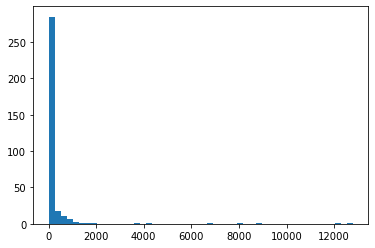

In [191]:
_=plt.hist(gdf_sliced_pu[gdf_sliced_pu["count"]<10000000000]["count"],bins=50)

In [21]:
def plot_chicago_heatmap(df,ax,h3_column,feature_column,h3_gdf,filter_min=0,filter_max=100000000000,cmap="plasma",xlim=False,ylim=False):
    data = df[[h3_column,feature_column]]
    data = pd.merge(h3_gdf,data,how="left",left_on="h3_id",right_on=h3_column)
    data[feature_column] = data[feature_column].fillna(0)
    data_outside = data[(data[feature_column]<=filter_min) | (data[feature_column]>=filter_max)]
    data_inside = data[(data[feature_column]>filter_min) & (data[feature_column]<filter_max)]
    
    
    chicago_fence.plot(ax=ax,edgecolor="white",color="none")
    data_outside.plot(ax=ax,color="grey",alpha=0.5,edgecolor="none")
    plot = data_inside.plot(ax=ax,column=feature_column,cmap=cmap)
    ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    return plot

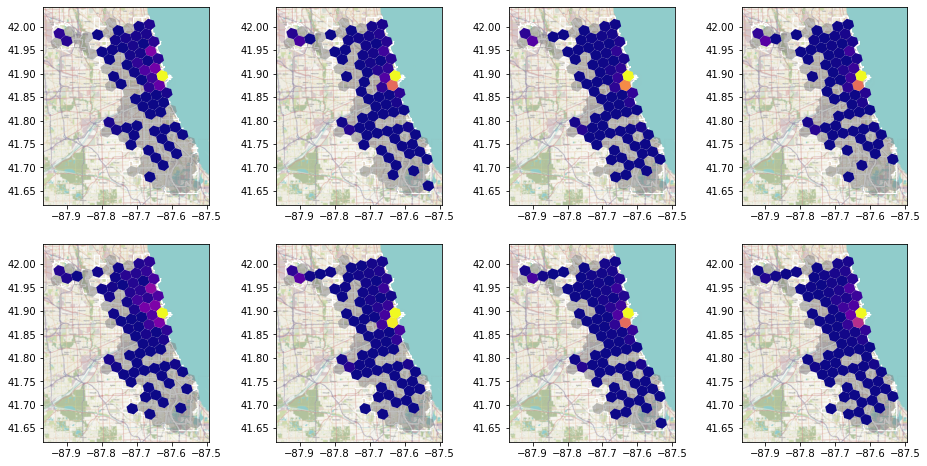

In [22]:
fig,axes = plt.subplots(2,4,figsize = (16,8))

i = 0
for ax in axes[0]:
    plot_df = gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,filter_min=0,filter_max=20000)#xlim=(-87.75,-87.6),ylim=(41.85,41.975))
    i=i+1
    
i = 0
for ax in axes[1]:
    plot_df = gdf_sliced_do[gdf_sliced_do["hour_slice"]==i]
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,filter_min=0,filter_max=20000)#xlim=(-87.75,-87.6),ylim=(41.85,41.975))
    i=i+1

<AxesSubplot:>

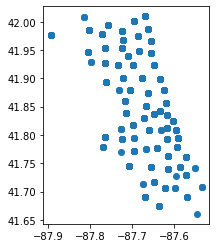

In [243]:
kepler_gdf.plot()

In [248]:
from keplergl import KeplerGl

kepler_df = df_geo.copy()
kepler_df = kepler_df[~kepler_df["Pickup Community Area"].isnull() & ~kepler_df["Dropoff Community Area"].isnull()]
kepler_df["Pickup Community Area"] = kepler_df["Pickup Community Area"].astype(int)
kepler_df["Dropoff Community Area"] = kepler_df["Dropoff Community Area"].astype(int)
kepler_df = kepler_df.groupby(["Pickup Community Area","Dropoff Community Area","PU_HOUR"]).agg(PU=("Pickup Community Area","min"),
                                                                                               DO =("Pickup Community Area","min"),
                                                                                               HOUR =  ("PU_HOUR","mean"),
                                                                                               mph = ("mph","median"))

com_area_geo = chicago_fence[["area_num_1","centroid"]]

kepler_df=pd.merge(kepler_df,com_area_geo,how="left",left_on="PU",right_on="area_num_1")
kepler_df = kepler_df.rename(columns={"centroid":"PU_centroid"})
kepler_df = kepler_df.drop(columns="area_num_1")

kepler_df=pd.merge(kepler_df,com_area_geo,how="left",left_on="DO",right_on="area_num_1")
kepler_df = kepler_df.rename(columns={"centroid":"DO_centroid"})
kepler_df = kepler_df.drop(columns="area_num_1")

kepler_df
kepler_gdf = gpd.GeoDataFrame(kepler_df,geometry="DO_centroid")
kepler_gdf = gpd.GeoDataFrame(kepler_gdf,geometry="PU_centroid")

keplermap = KeplerGl(height=400)
keplermap.add_data(data=kepler_df, name="points")
keplermap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


ValueError: Can't clean for JSON: <shapely.geometry.point.Point object at 0x000001740D811310>

In [138]:
df_grouped_pu = df.groupby("PU_H3").agg(avgduration=("Trip Seconds","mean"),
                                        avgdistance=("Trip Miles","mean"),
                                        avgpay=("Trip Total","mean"),
                                        count=("Trip Total","count"),
                                        revenue=("Trip Total","sum"),
                                        H3=("PU_H3","min"))

df_grouped_pu["revenue_per_ride"] = df_grouped_pu["revenue"]/df_grouped_pu["count"]

In [139]:
df_grouped_pu

,avgduration,avgdistance,avgpay,count,revenue,H3,revenue_per_ride
PU_H3,,,,,,,
872664191ffffff,1552.454545,10.067273,28.640909,11,315.05,872664191ffffff,28.640909
872664196ffffff,1340.547619,5.676190,23.305238,84,1957.64,872664196ffffff,23.305238
8726641b2ffffff,2216.823529,14.200588,42.264706,17,718.50,8726641b2ffffff,42.264706
872664520ffffff,1687.042640,10.955341,41.232397,6121,252383.50,872664520ffffff,41.232397
872664521ffffff,1880.289754,11.600942,44.441488,14571,647556.92,872664521ffffff,44.441488
...,...,...,...,...,...,...,...
87275934cffffff,1240.426230,7.827541,28.811475,61,1757.50,87275934cffffff,28.811475
87275934effffff,2275.362801,14.812195,53.211072,50937,2710412.38,87275934effffff,53.211072
872759369ffffff,1096.757835,5.910342,22.580299,702,15851.37,872759369ffffff,22.580299


Text(0.5, 1.0, 'Duration')

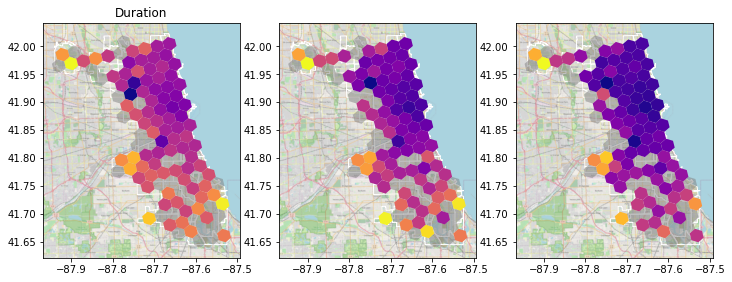

In [140]:
fig,axes = plt.subplots(1,3,figsize=(12,8))
duration_plot = plot_chicago_heatmap(df_grouped_pu,axes[0],"H3","avgduration",h3_gdf)
distance_plot = plot_chicago_heatmap(df_grouped_pu,axes[1],"H3","avgdistance",h3_gdf)
revenue_plot = plot_chicago_heatmap(df_grouped_pu,axes[2],"H3","revenue_per_ride",h3_gdf)

axes[0].set_title("Duration")

## Write results in parquet file 